In [ ]:
from obspy.clients.seedlink.easyseedlink import create_client
from obspy import Trace, UTCDateTime, Stream
from obspy.clients.fdsn import Client as FDSNclient
from obspy.core.inventory import Inventory
import matplotlib.pyplot as plt
import time
from obspy import UTCDateTime
from bs4 import BeautifulSoup
import requests
import logging.handlers
import numpy as np
import logging, os
from multiprocessing import Queue
import pandas as pd
from src.filtering import filtering_data
from src.fourier import fourier_transform
from src.core import main_processing
import joblib


ModuleNotFoundError: No module named 'src'

In [ ]:
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
directory_path = os.path.join(root_dir, 'dbs') # Change this to your folder path
file_path = os.path.join(directory_path, "processed_ds2_partial.csv")

datasource = pd.read_csv(file_path, index_col="index")

In [ ]:
datasource.columns

In [ ]:
columns_datasource = ['index', 'datetime', 'lat', 'lon', 'depth', 'mag', 'Rms', 'Int',
       'sensed', 'lat_decimal', 'lon_decimal', 'dist_MORF', 'Domin_freq_z',
       'Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c', 'S-peak2peak',
       'S-Vel amp (m/s)', 'RMS', 'S-Disp amp (m)', 'S-r', 'Energy',
       'S-moment_history', 'peak_freq', 'S-tau_c', 'wavelength', 'other infos',
       'peak_disp', 'M0']

In [ ]:
def classify(row):
    if row == "V/VI":
        return 6
    elif row == "V":
        return 5
    elif row == "IV/V":
        return 4.5
    elif row == "IV":
        return 4
    elif row =="III/IV":
        return 3.5
    elif row == "III":
        return 3
    elif row =="II/III":
        return 2.5
    elif row =="II":
        return 2
    elif row == "I/II":
        return 1.5
    elif row == "I":
        return 1
    else:
        return 0

datasource["num_int"] = datasource["Int"].apply(lambda x :classify(x))

In [ ]:
datasource2= datasource.__deepcopy__()

datasource2 = datasource2.drop(["Int", "lat", "lon", "Rms", "mag"], axis=1)
datasource2.isna().sum()
datasource2 = datasource2.dropna(axis=0)

datasource2["Domin_freq_n"] = abs(datasource2["Domin_freq_n"])
datasource2["Domin_freq_e"] = abs(datasource2["Domin_freq_e"])
datasource2["Domin_freq_z"] = abs(datasource2["Domin_freq_z"])
datasource2["P-Vel amp (m/s)"] = abs(datasource2["P-Vel amp (m/s)"])
datasource2["S-Vel amp (m/s)"] = abs(datasource2["S-Vel amp (m/s)"])
datasource2["P-Disp amp (m)"] = abs(datasource2["P-Disp amp (m)"])
datasource2["S-Disp amp (m)"] = abs(datasource2["S-Disp amp (m)"])

datasource2["Mw"] = 4.525*np.log10(datasource2["P-tau_c"]) +5.036

datasource2["sensed_n"] = datasource2["num_int"].apply(lambda x: 1 if x > 2.5 else 0) 
datasource2.loc[datasource2["sensed_n"] == 1, "dist_MORF"] = datasource2.loc[datasource2["sensed_n"] == 1, "dist_MORF"].apply(lambda x: 0 if x > 627 else 1)

true_features = datasource2[['Domin_freq_z','Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c'
       #,'S-peak2peak','S-Vel amp (m/s)','S-Disp amp (m)', 'S-r','S-moment_history', 'S-tau_c'
       ,'RMS',  'Energy','peak_freq', 'wavelength', 'other infos', 'peak_disp', 'M0', "Mw"]]

target = datasource2[["sensed_n"]]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming datasource2 is your DataFrame
# If you have missing or NaN values, you may need to handle those
# For now, let's proceed assuming it's clean, or you can adjust later if needed

# 1. Data Overview
print("=== Data Overview ===")
print(datasource2.describe())  # Summary statistics for numerical columns

# 2. Distribution of Each Column (Histograms and Boxplots)
# Create histograms and boxplots for continuous features

# List of columns to analyze
numeric_columns = ['Domin_freq_z', 'Domin_freq_n', 'Domin_freq_e', 'P-peak2peak', 'P-Vel amp (m/s)',
                   'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c', 'RMS',  'Energy', 
                   'peak_freq', 'wavelength', 'peak_disp', 'M0', "Mw"]

# Create a grid of plots
fig, axes = plt.subplots(len(numeric_columns), 2, figsize=(12, 3 * len(numeric_columns)))

for i, col in enumerate(numeric_columns):
    # Histogram
    sns.histplot(datasource2[col], ax=axes[i, 0], color='skyblue', bins=30)
    axes[i, 0].set_title(f"Histogram of {col}")
    
    # Boxplot
    sns.boxplot(x=datasource2[col], ax=axes[i, 1], color='lightgreen')
    axes[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# 3. Correlation Analysis
# Correlation matrix of numeric columns
#corr_matrix = datasource2[numeric_columns].corr()

# Plot correlation matrix using heatmap
#plt.figure(figsize=(12, 8))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#plt.title('Correlation Matrix')
#plt.show()

# 4. Summary of Categorical Data (if applicable)
# If you have categorical columns, you can check their distribution too
# For example, assuming 'other infos' is categorical
#if 'other infos' in datasource2.columns:
#    print("\n=== Categorical Data Distribution ===")
#    print(datasource2['other infos'].value_counts())

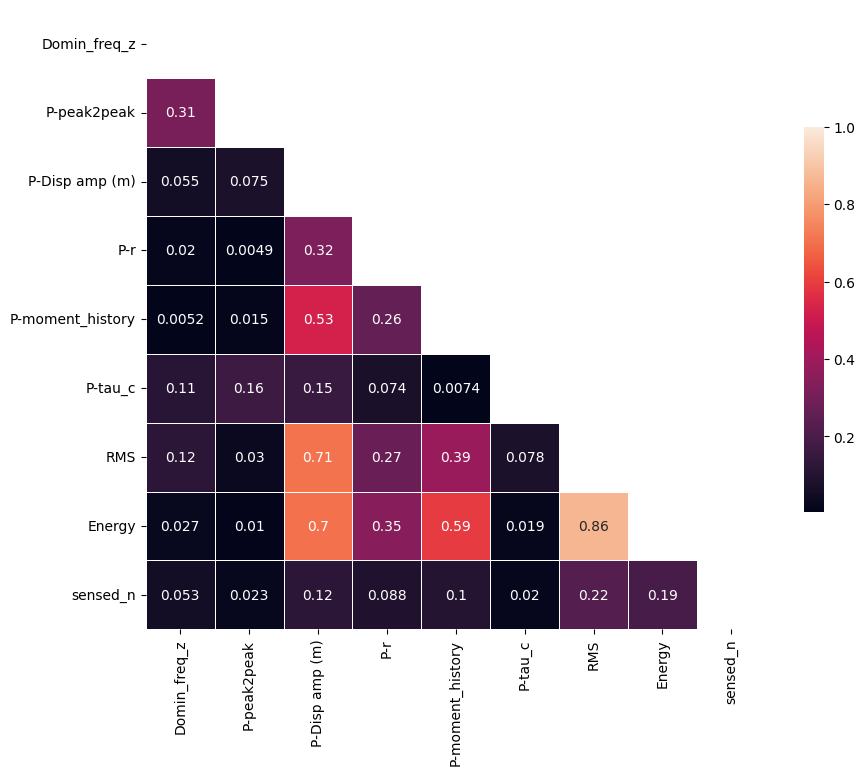

In [ ]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

features = datasource2[['Domin_freq_z','P-peak2peak', #'P-Vel amp (m/s)',
       'P-Disp amp (m)', 'P-r', 'P-moment_history', 'P-tau_c', "Mw"
       #,'S-peak2peak','S-Vel amp (m/s)','S-Disp amp (m)', 'S-r','S-moment_history', 'S-tau_c'
       ,'RMS'
       ,'Energy',
       #, 'other infos', 
       "sensed_n"
       ]]

corr=np.abs(features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()



In [358]:
## starting ML
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, precision_score, accuracy_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [359]:
features = features.drop("sensed_n", axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)
y_test = np.array(y_test).ravel()

In [270]:
# Normalize only the numerical features
normalizer = MinMaxScaler()
normalizer.fit(X_train)

# Transform the numerical features
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Convert to DataFrame, keeping the original indices
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)

In [363]:
linear_reg = LinearRegression()
linear_reg.fit(X_train_norm, y_train)
lin_pred = linear_reg.predict(X_test_norm)

print("MAE", mean_absolute_error(lin_pred, y_test))
print("RMSE", root_mean_squared_error(lin_pred, y_test))
print("R2 score", linear_reg.score(X_test_norm, y_test))

MAE 0.0074246958120308595
RMSE 0.04917414056038437
R2 score -0.0010976545042007402


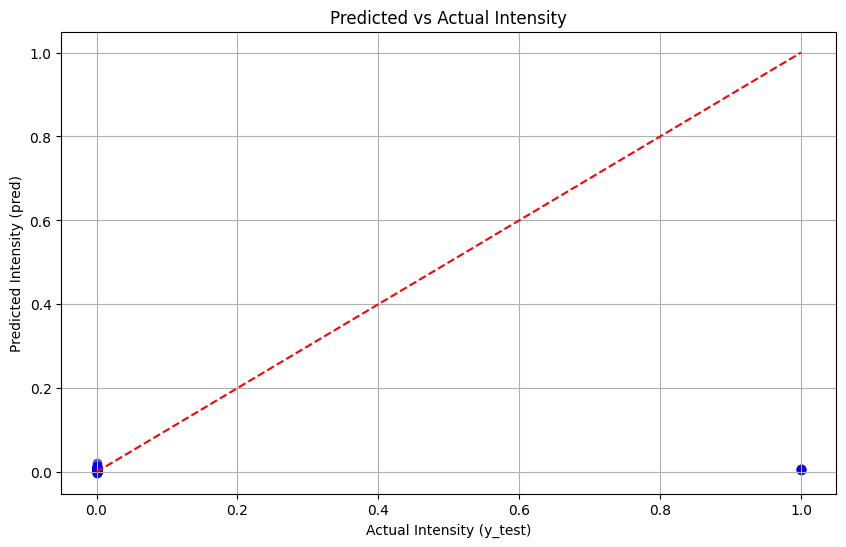

In [364]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lin_pred, color='b', alpha=0.6)

# Adding a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='r', linestyle='--')

# Adding labels and title
plt.xlabel('Actual Intensity (y_test)')
plt.ylabel('Predicted Intensity (pred)')
plt.title('Predicted vs Actual Intensity')

# Show grid
plt.grid()

# Show the plot
plt.show()

In [365]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20)

y_train = np.array(y_train).ravel()
y_test = np.array(y_test).ravel()

In [402]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Normalize only the numerical features
normalizer = MinMaxScaler()
normalizer.fit(X_train)

# Transform the numerical features
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Convert to DataFrame, keeping the original indices
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns)
X_test_norm_indexed = pd.DataFrame(normalizer.transform(X_test), columns=X_test.columns, index=X_test.index)

In [367]:
## resampling
train = pd.DataFrame(X_train_norm, columns=X_train.columns)
train["sensed_n"] = y_train

sensed_df = train[train["sensed_n"]==1]
not_sensed_df = train[train["sensed_n"]==0]

In [368]:
from sklearn.utils import resample

fraud_df_oversampled = resample(sensed_df, n_samples=len(not_sensed_df), replace=True)
train_oversampled = pd.concat([fraud_df_oversampled, not_sensed_df])

In [369]:
y_train_over = train_oversampled["sensed_n"]
X_train_over = train_oversampled.drop(columns="sensed_n")

y_train_over = np.array(y_train_over).ravel() 

In [378]:
gb_reg = GradientBoostingClassifier(max_depth=20,
                                   n_estimators=200)
gb_reg.fit(X_train_over, y_train_over)
gb_pred = gb_reg.predict(X_test_norm)

precision = precision_score(y_test, gb_pred)
accuracy = accuracy_score(y_test, gb_pred)
recall = recall_score(y_test, gb_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.993543179983858
Precision: 0.0
Recall: 0.0


In [376]:
ada_reg = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20),
                            n_estimators=200)

ada_reg.fit(X_train_over, y_train_over)
ada_pred = ada_reg.predict(X_test_norm)

precision = precision_score(y_test, ada_pred)
accuracy = accuracy_score(y_test, ada_pred)
recall = recall_score(y_test, ada_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9931396287328491
Precision: 0.0
Recall: 0.0


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [377]:
forest = RandomForestClassifier(n_estimators=200, max_depth=20)
forest.fit(X_train_over, y_train_over)
forest_pred = forest.predict(X_test_norm)

precision = precision_score(y_test, forest_pred)
accuracy = accuracy_score(y_test, forest_pred)
recall = recall_score(y_test, forest_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9963680387409201
Precision: 0.0
Recall: 0.0


In [189]:
bagging_reg = BaggingClassifier(DecisionTreeClassifier(max_depth=20),                               
                               n_estimators=200,
                               max_samples = 1000,
                               #bootstrap = False,
                               n_jobs=-1
                               )

bagging_reg.fit(X_train_over, y_train_over)
bag_pred = bagging_reg.predict(X_test_norm)

precision = precision_score(y_test, bag_pred)
accuracy = accuracy_score(y_test, bag_pred)
recall = recall_score(y_test, bag_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9733656174334141
Precision: 0.03333333333333333
Recall: 0.2


In [190]:
grid = {"n_estimators": [250, 500, 750],
        "estimator__max_leaf_nodes": [150, 180, 250],
        "estimator__max_depth":[5,10]}

bagging_reg = BaggingClassifier(DecisionTreeClassifier())

model = GridSearchCV(estimator = bagging_reg, param_grid = grid, cv=5, n_jobs=-1)
model.fit(X_train_over, y_train_over)
model.best_params_

{'estimator__max_depth': 10,
 'estimator__max_leaf_nodes': 250,
 'n_estimators': 250}

In [191]:
best_model = model.best_estimator_

In [192]:
model_pred = best_model.predict(X_test_norm)

precision = precision_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9487489911218725
Precision: 0.01652892561983471
Recall: 0.2


In [379]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_norm, y_train)

y_train_sm = y_train_sm.ravel()


In [380]:
grid = {"n_estimators": [250, 320, 500, 750],
        "estimator__max_leaf_nodes": [200, 400, 500, 650],
        "estimator__max_depth":[10, 20,30,40]}

bagging_reg = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

model = GridSearchCV(estimator = bagging_reg, param_grid = grid, cv=5, n_jobs=-1)#, scoring='recall')
model.fit(X_train_sm, y_train_sm)
model.best_params_

{'estimator__max_depth': 40,
 'estimator__max_leaf_nodes': 500,
 'n_estimators': 320}

In [381]:
best_model = model.best_estimator_
model_pred = best_model.predict(X_test_norm)

precision = precision_score(y_test, model_pred)
accuracy = accuracy_score(y_test, model_pred)
recall = recall_score(y_test, model_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.976594027441485
Precision: 0.0
Recall: 0.0


In [382]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities with the best model
y_prob = model.best_estimator_.predict_proba(X_test_norm)[:, 1]  # Probabilities for the positive class

# Set a custom threshold
custom_threshold = 0.01  # For example, set to 0.3 to increase recall

# Make predictions based on the custom threshold
y_pred_custom_threshold = (y_prob >= custom_threshold).astype(int)


precision = precision_score(y_test, y_pred_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7348668280871671
Precision: 0.007587253414264037
Recall: 0.625


In [332]:
from sklearn.metrics import precision_recall_curve

# Predict probabilities with the best model
y_prob = model.best_estimator_.predict_proba(X_test_norm)[:, 1]  # Probabilities for the positive class

# Set a custom threshold
custom_threshold = 0.001  # For example, set to 0.3 to increase recall

# Make predictions based on the custom threshold
y_pred_custom_threshold = (y_prob >= custom_threshold).astype(int)


precision = precision_score(y_test, y_pred_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
recall = recall_score(y_test, y_pred_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7062146892655368
Precision: 0.012345679012345678
Recall: 0.5294117647058824


In [384]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_custom_threshold)

# Extract values
TN, FP, FN, TP = cm.ravel()

# Print the values
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")

True Negatives (TN): 1816
False Positives (FP): 654
False Negatives (FN): 3
True Positives (TP): 5


In [ ]:
# Specify the save folder
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
directory_path = os.path.join(root_dir, 'models')
os.makedirs(directory_path, exist_ok=True)
model_path = os.path.join(directory_path, "model_FINAL.pkl")
est_path = os.path.join(directory_path, "est_model_FINAL.pkl")

# Assuming `model` is your trained model
#joblib.dump(model, model_path)
#joblib.dump(model, est_path)

['est_model_FINAL.pkl']

In [430]:
datasource2[["sensed_n"]].value_counts()

sensed_n
0           12333
1              56
Name: count, dtype: int64

In [486]:
check = pd.DataFrame()
check["test"] = y_test
check["pred"] = y_pred_custom_threshold
check = pd.concat([check, X_test_norm], axis = 1)
X_test_norm_indexed = pd.DataFrame(normalizer.transform(X_test), columns=X_test.columns, index=X_test.index)
X_test_norm_indexed = X_test_norm_indexed.merge(X_test, how="outer", left_index=True, right_index=True)
X_test_norm_indexed_reset = X_test_norm_indexed.reset_index().rename(columns={"Energy_x": "Energy"})
check2 = check.merge(right=X_test_norm_indexed_reset,how="outer", on="Energy")
check2.set_index('index', inplace=True)
print(check2[(check2["pred"]==1)&(check2["test"]==1)].index)
datasource.loc[21070]

Index([14653, 18187, 19132, 18082, 5359], dtype='int64', name='index')


index                                 21070
datetime            2018-08-07T06:34:36.400
lat                                41.686°N
lon                                08.450°W
depth                                  16.0
mag                                     3.2
Rms                                     0.3
Int                                      IV
sensed                                    1
lat_decimal                          41.686
lon_decimal                           -8.45
dist_MORF                        487.530283
Domin_freq_z                            4.8
Domin_freq_n                           -4.8
Domin_freq_e                         -4.825
P-peak2peak                        0.106667
P-Vel amp (m/s)                         0.0
P-Disp amp (m)                          0.0
P-r                                0.000004
P-moment_history                        0.0
P-tau_c                         3132.165204
S-peak2peak                        0.106667
S-Vel amp (m/s)                 

2455


In [204]:
false_negatives_indices = np.where((y_test == 1) & (y_pred_custom_threshold == 0))[0]
display(false_negatives_indices)
datasource2.iloc[1239]
print(f"y_test[1952]: {y_test[1239]}")
print(f"X_test[1952]: {X_test_norm.iloc[1239]}")

array([ 198,  767,  977, 1239, 2367])

y_test[1952]: 1
X_test[1952]: Domin_freq_z        0.649150
Domin_freq_n        0.288474
Domin_freq_e        0.400745
P-peak2peak         0.421488
P-Vel amp (m/s)     0.000451
P-Disp amp (m)      0.000372
P-r                 0.000045
P-moment_history    0.268885
P-tau_c             0.210734
RMS                 0.006733
Energy              0.000047
peak_freq           0.649150
wavelength          0.090349
other infos         0.001609
peak_disp           0.181079
M0                  0.181079
Mw                  0.762448
Name: 1239, dtype: float64


Accuracy: 0.7978208232445521
Precision: 0.011928429423459244
Recall: 0.6

In [206]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import BalancedBaggingClassifier

# Define grid for BalancedBaggingClassifier
param_grid = {
    'n_estimators': [100, 250, 500, 1000],
    'max_samples': [0.5, 0.75, 0.8],
    'max_features': [0.3, 0.5, 0.75],
    'estimator__max_depth': [10, 20, 30 , 50]  # Depth of the Decision Tree estimator
}

# Initialize the classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'))

# Run grid search
grid_search = GridSearchCV(bagging, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_sm, y_train_sm)

# Retrieve best parameters and use them in the stacking model
best_params = grid_search.best_params_
print("Best parameters for BalancedBaggingClassifier:", best_params)

# Define base models
base_models = [
    ('bagging', BaggingClassifier(
        estimator=DecisionTreeClassifier(class_weight='balanced'),
        n_estimators=best_params['n_estimators'],
        max_samples=best_params['max_samples'],
        max_features=best_params['max_features']
    )),
    ('random_forest', RandomForestClassifier(class_weight='balanced', n_estimators=best_params['n_estimators'])),
    ('gradient_boosting', GradientBoostingClassifier(n_estimators=best_params['n_estimators']))
]

# Define the stacking model with a meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict with the custom threshold on the stacking model
y_prob_stack = stacking_model.predict_proba(X_test_norm)[:, 1]  # Positive class probabilities
custom_threshold = 0.05  # Example threshold
y_pred_stack_custom_threshold = (y_prob_stack >= custom_threshold).astype(int)

precision = precision_score(y_test, y_pred_stack_custom_threshold ,zero_division=1)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for BalancedBaggingClassifier: {'estimator__max_depth': 30, 'max_features': 0.3, 'max_samples': 0.8, 'n_estimators': 500}
Accuracy: 0.9895076674737692
Precision: 0.05555555555555555
Recall: 0.1


In [207]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Define base models
base_models = [
    ('brf', BalancedRandomForestClassifier(n_estimators=150, max_depth=30, class_weight='balanced_subsample')),
    ('xgb', xgb.XGBClassifier(scale_pos_weight=15, max_depth=7, min_child_weight=2, use_label_encoder=False, eval_metric='logloss')),
    ('lgb', lgb.LGBMClassifier(class_weight={0: 1, 1: 15}, n_estimators=150, num_leaves=50))
]

## Define the stacking model with a logistic regression meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5)
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict probabilities with the stacking model
y_prob_stacking = stacking_model.predict_proba(X_test_norm)[:, 1]  # Probability for the positive class

# Apply the custom threshold
custom_threshold = 0.01
y_pred_stack_custom_threshold = (y_prob_stacking >= custom_threshold).astype(int)

# Convert y_test to 1D NumPy array
y_test = np.array(y_test).ravel()  # or simply use y_test.values.ravel()

# Evaluate the stacking model
precision = precision_score(y_test, y_pred_stack_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9865, number of negative: 9865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937500 -> initscore=2.708050
[LightGBM] [Info] Start training from score 2.708050


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7892, number of negative: 7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15784, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.937500 -> initscore=2.708050
[LightGBM] [Info] Start training from score 2.708050
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7892, number of negative: 7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15784, number of used featu

In [208]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids for hyperparameter tuning
param_grid_brf = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10],
    'scale_pos_weight': [5, 10, 15]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 150],
    'num_leaves': [31, 50, 100],
    'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 30}]
}

# Initialize base models
brf = BalancedRandomForestClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier()

# Perform RandomizedSearchCV on each model
random_search_brf = GridSearchCV(brf, param_grid_brf, cv=5, scoring='recall', n_jobs=-1)
random_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, scoring='recall', n_jobs=-1)
random_search_lgb = GridSearchCV(lgb_model, param_grid_lgb, cv=5, scoring='recall', n_jobs=-1)

# Fit each search to find the best model
random_search_brf.fit(X_train_sm, y_train_sm)
random_search_xgb.fit(X_train_sm, y_train_sm)
random_search_lgb.fit(X_train_sm, y_train_sm)

# Retrieve best estimators
best_brf = random_search_brf.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_lgb = random_search_lgb.best_estimator_

# Display best parameters
print("Best parameters for BalancedRandomForestClassifier:", random_search_brf.best_params_)
print("Best parameters for XGBClassifier:", random_search_xgb.best_params_)
print("Best parameters for LGBMClassifier:", random_search_lgb.best_params_)

# Define base models with best parameters
base_models = [
    ('brf', best_brf),
    ('xgb', best_xgb),
    ('lgb', best_lgb)
]

# Define the stacking model with a GradientBoostingClassifier as the meta-classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5)
)

# Train the stacking model on the oversampled data
stacking_model.fit(X_train_sm, y_train_sm)

# Predict probabilities with the stacking model
y_prob_stacking = stacking_model.predict_proba(X_test_norm)[:, 1]  # Probability for the positive class

# Apply the custom threshold
custom_threshold = 0.01
y_pred_stack_custom_threshold = (y_prob_stacking >= custom_threshold).astype(int)

# Evaluate the stacking model
precision = precision_score(y_test, y_pred_stack_custom_threshold)
accuracy = accuracy_score(y_test, y_pred_stack_custom_threshold)
recall = recall_score(y_test, y_pred_stack_custom_threshold)

print("\nStacking Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9865, number of negative: 9865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909091 -> initscore=2.302585
[LightGBM] [Info] Start training from score 2.302585
Best parameters for BalancedRandomForestClassifier: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Best parameters for XGBClassifier: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 15}
Best parameters for LGBMClassifier: {'class_weight': {0: 1, 1: 10}, 'n_estimators': 50, 'num_leaves': 31}


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 9865, number of negative: 9865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909091 -> initscore=2.302585
[LightGBM] [Info] Start training from score 2.302585


c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\Utilizador\Desktop\IRONHACK\.venv\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7892, number of negative: 7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15784, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.909091 -> initscore=2.302585
[LightGBM] [Info] Start training from score 2.302585
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 7892, number of negative: 7892
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 15784, number of used featu